In [2]:
%reload_ext autoreload
%autoreload 2
import os
from pathlib import Path
import numpy as np
import pandas as pd
from aldiscore.prediction import utils

In [ ]:
data_dir = Path("/hits/fast/cme/bodynems/data/paper")
feat_df, drop_df, label_df = utils.load_features(
    data_dir,
    # exclude_sources=["sabre"],
    exclude_features=["is_dna", "num_seqs", "seq_length"],
)
print(feat_df.shape)
print(drop_df.shape)
print(label_df.shape)

Dropping 0 NaN rows...
(11008, 469)
(11008, 21)
(11008, 1)


In [3]:
# # # TEST PERFORMANCE ON WITHHELD DATA
# excluded = "sabre"
# dnaf_idxs = feat_df.query(f"source == '{excluded}'").index.copy()
# dnaf_feats = feat_df.loc[dnaf_idxs].copy()
# dnaf_labels = label_df.loc[dnaf_idxs].copy()
# feat_df = feat_df.drop(dnaf_idxs, axis=0)
# label_df = label_df.drop(dnaf_idxs, axis=0)

In [7]:
# print("max num seqs", drop_df["num_seqs"].max())
# print("max seq len", drop_df["max:seq_length"].max())

In [ ]:
from aldiscore import ROOT

RSTATE = 0

In [ ]:
from sklearn.model_selection import train_test_split

train_idxs, test_idxs = train_test_split(
    feat_df.index.to_list(), test_size=0.2, random_state=RSTATE
)
test_idxs, valid_idxs = train_test_split(test_idxs, test_size=0.5, random_state=RSTATE)
print(len(train_idxs), len(test_idxs), len(valid_idxs))

9144 1143 1144


In [12]:
if use_lgb:
    import lightgbm as lgb

    # Create LightGBM dataset
    train_data = lgb.Dataset(
        feat_df.loc[train_idxs],
        label=label_df.loc[train_idxs].to_numpy().ravel(),
    )
    test_data = lgb.Dataset(
        feat_df.loc[test_idxs],
        label=label_df.loc[test_idxs].to_numpy().ravel(),
    )
    valid_data = lgb.Dataset(
        feat_df.loc[valid_idxs],
        label=label_df.loc[valid_idxs].to_numpy().ravel(),
    )

    clean_feat_names = feat_df.columns.str.replace(":", "-").to_list()
    train_data = train_data.set_feature_name(clean_feat_names)
    test_data = test_data.set_feature_name(clean_feat_names)
    valid_data = valid_data.set_feature_name(clean_feat_names)
    # Set parameters for regression
    params = {
        "objective": "rmse",
        "learning_rate": 0.01,
        "metric": "l2,l1",
        "verbosity": 1,
        # "max_depth": 7,
        "seed": RSTATE,
        "num_leaves": 41,
        # "feature_fraction_bynode": 0.5,
        "feature_fraction": 0.2,
        "bagging_fraction": 0.67,
        # "bagging_freq": 5,
        # "early_stopping_rounds": 100,
        "num_threads": 2,
    }

    # Train the model
    num_round = 4000
    model = lgb.train(params, train_data, num_round, valid_sets=[valid_data])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 113673
[LightGBM] [Info] Number of data points in the train set: 9144, number of used features: 468
[LightGBM] [Info] Start training from score 0.153436


In [13]:
y_pred = model.predict(feat_df.loc[valid_idxs])
y_true = label_df.loc[valid_idxs].to_numpy().ravel()
# mask = y_true > 0.1
# y_pred = y_pred[mask]
# y_true = y_true[mask]

# y_pred = model.predict(dnaf_feats)
# y_true = dnaf_labels.to_numpy().ravel()

In [14]:
eps = 1e-2

rmse = (((y_pred - y_true) ** 2).sum() / len(y_true)) ** 0.5
rmspe = (((y_pred - y_true) ** 2 / (y_true + eps)).sum() / len(y_true)) ** 0.5
mae = (np.abs(y_pred - y_true)).sum() / len(y_true)
mape = (np.abs(y_pred - y_true) / (y_true + eps)).sum() / len(y_true)
mape_p50 = np.percentile(np.abs(y_pred - y_true) / (y_true + eps), 50)
corr = np.corrcoef(y_true, y_pred)[0, 1]
print(f"[RMSE] {rmse:.4f}")
print(f"[RMSPE] {rmspe:.4f}")
print(f"[MAE] {mae:.4f}")
print(f"[MAPE] {mape:.4f}")
print(f"[MAPE_P50] {mape_p50:.4f}")
print(f"[CORR] {corr:.4f}")
print(np.sort(np.abs(y_pred - y_true) / (y_true + eps))[::-1][:20])

[RMSE] 0.0415
[RMSPE] 0.1010
[MAE] 0.0241
[MAPE] 0.2440
[MAPE_P50] 0.1435
[CORR] 0.9727
[6.73676789 4.92178023 3.9134408  2.62519623 2.33760231 2.24716898
 2.05278382 1.8253861  1.78171289 1.65435158 1.61272508 1.59622448
 1.58668528 1.51035614 1.5081942  1.41602258 1.32192227 1.30947527
 1.30638628 1.27425981]


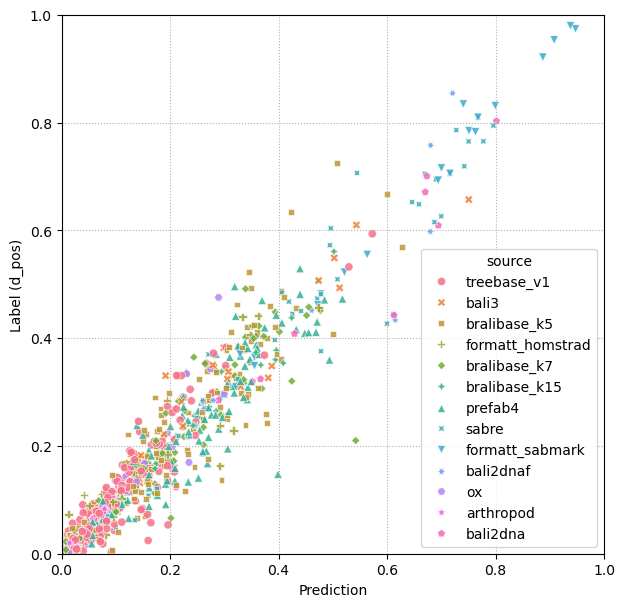

In [15]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[valid_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 7))
sn.scatterplot(x=y_pred, y=y_true, alpha=0.85, style=sources, hue=sources)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

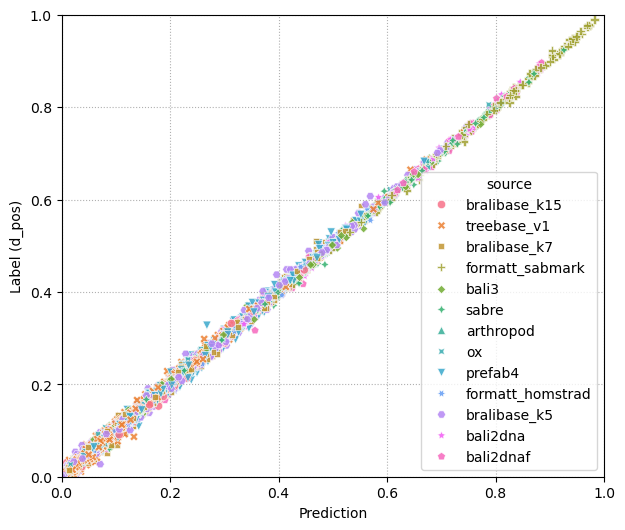

In [16]:
import seaborn as sn
import matplotlib.pyplot as plt

sources = feat_df.loc[train_idxs].reset_index().loc[:, "source"]
plt.figure(figsize=(7, 6))
sn.scatterplot(
    x=model.predict(feat_df.loc[train_idxs]),
    y=label_df.loc[train_idxs].to_numpy().ravel(),
    alpha=0.85,
    style=sources,
    hue=sources,
)
plt.xlabel("Prediction")
plt.ylabel("Label (d_pos)")
# plt.xticks(np.linspace(0, 1, 5, endpoint=True))
# plt.yticks(np.linspace(0, 1, 5, endpoint=True))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(linestyle=":")
# sn.scatterplot(
#     x=y_pred,
#     y=y_true,
#     alpha=0.5,
#     style=sources,
#     hue=is_dna.loc[test_idxs].reset_index(drop=True),
# )

In [17]:
test = feat_df.copy()
test["label"] = label_df["mean"]
corr = test.corr().loc["label"]
corr = corr.iloc[corr.abs().argsort()[::-1]]
corr[:20]

label                1.000000
p70:tc_base_p50     -0.885261
p70:tc_base_mean    -0.883455
p70:tc_base_min     -0.882662
mean:tc_base_p50    -0.882356
p60:tc_base_p50     -0.882130
mean:tc_base_mean   -0.881187
p60:tc_base_mean    -0.881015
mean:tc_base_max    -0.880528
p70:tc_base_max     -0.879801
mean:tc_base_min    -0.879684
p60:tc_base_max     -0.879450
p60:tc_base_min     -0.879217
p50:tc_base_p50     -0.874936
p50:tc_base_mean    -0.874196
p50:tc_base_max     -0.874180
p80:tc_base_p50     -0.872961
p50:tc_base_min     -0.872034
p80:tc_base_min     -0.871198
p80:tc_base_mean    -0.870324
Name: label, dtype: float64

In [18]:
if use_lgb:
    imps = model.feature_importance(importance_type="gain")
else:
    imps = model.feature_importances_
imp_df = pd.DataFrame(dict(feature=feat_df.columns, importance=imps))
imp_df = imp_df.sort_values("importance", ignore_index=True, ascending=False)
imp_df[:10]
imp_df[imp_df.feature.str.contains("mer")].iloc[:10]
# np.save(ROOT / "top_feats.npy", imp_df.feature[:50].to_numpy())

,feature,importance
19,iqr:9mer_ent,108.141629
30,iqr:7mer_ent,47.853895
34,std:9mer_ent,34.864398
46,std:5mer_ent,19.181500
53,std:7mer_ent,16.615715
66,iqr:9mer_js,12.047336
73,p5:5mer_js,11.114052
77,p5:9mer_js,10.383548
85,std:5mer_js,9.045820
87,p60:5mer_ent,8.907947


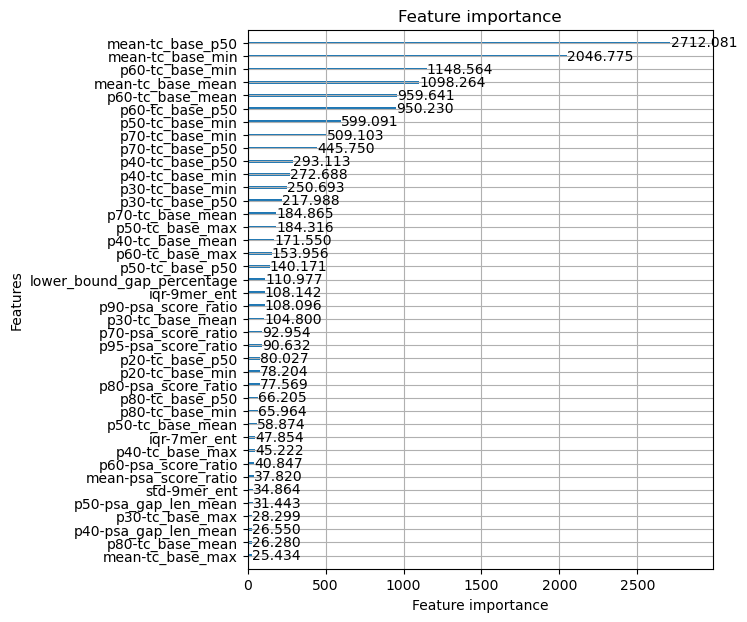

In [19]:
if use_lgb:
    lgb.plot_importance(
        model, figsize=(6, 7), importance_type="gain", max_num_features=40
    )
else:
    pass
    # sn.barplot(x=feat, y=importance[sort_idxs], hue=is_tc)
    # ax = plt.gca()
    # _ = ax.set_xticklabels([])
    # _ = ax.legend(title="Consistency-based")
    # _ = ax.set_ylabel("Feature importance")
    # _ = ax.set_xlabel("Features")
    # print(top_feats[:30])